C:\Users\Thanish\AppData\Local\Temp\ipykernel_29332\3689592521.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({


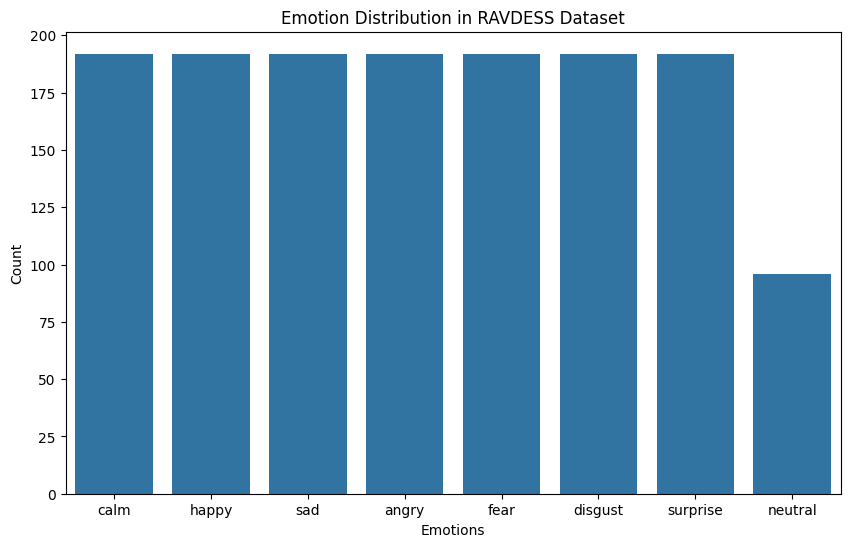

C:\Users\Thanish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Thanish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.2001 - loss: 2.5291 - val_accuracy: 0.1794 - val_loss: 2.0285 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.2343 - loss: 2.0788 - val_accuracy: 0.1823 - val_loss: 2.1126 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.2614 - loss: 1.9387 - val_accuracy: 0.2378 - val_loss: 2.1458 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.3056 - loss: 1.8154 - val_accuracy: 0.2772 - val_loss: 2.0852 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.3221 - loss: 1.7513 - val_accuracy: 0.2922 - val_loss: 2.1024 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.3651 - loss: 1.6823 - val_accuracy: 0.3559 - val_loss: 1.7573 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accura

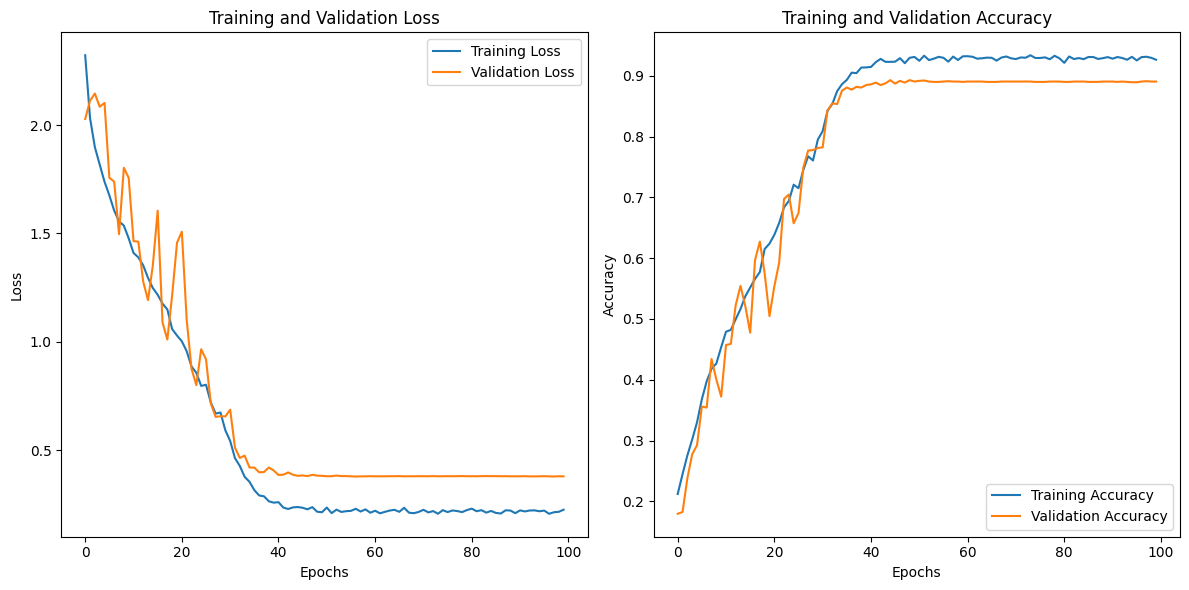

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


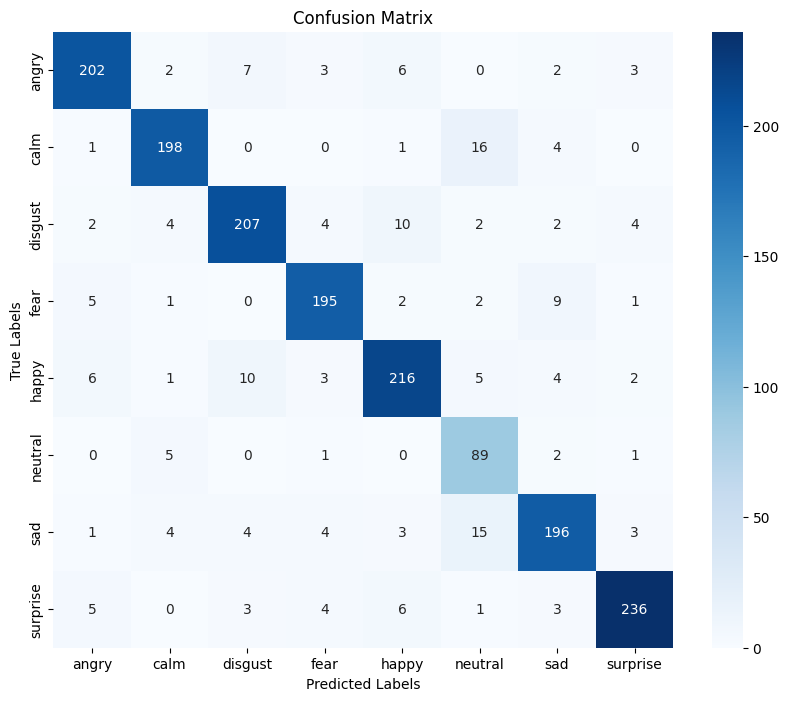

Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.90      0.90       225
        calm       0.92      0.90      0.91       220
     disgust       0.90      0.88      0.89       235
        fear       0.91      0.91      0.91       215
       happy       0.89      0.87      0.88       247
     neutral       0.68      0.91      0.78        98
         sad       0.88      0.85      0.87       230
    surprise       0.94      0.91      0.93       258

    accuracy                           0.89      1728
   macro avg       0.88      0.89      0.88      1728
weighted avg       0.89      0.89      0.89      1728



In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# Load RAVDESS data
Ravdess = "Data/Ravdess/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

# Plot emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=Ravdess_df, x='Emotions', order=Ravdess_df['Emotions'].value_counts().index)
plt.title('Emotion Distribution in RAVDESS Dataset')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

# Audio augmentation functions
def add_noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def time_stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, steps=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=steps)

def random_crop(data, sampling_rate, duration=2.5):
    max_offset = len(data) - int(duration * sampling_rate)
    if max_offset > 0:
        offset = np.random.randint(0, max_offset)
        data = data[offset:offset + int(duration * sampling_rate)]
    return data

def reverse_audio(data):
    return data[::-1]

# Feature extraction function
def extract_features(data, sample_rate):
    result = np.array([])
    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    # Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

# Collect features and labels with augmentation
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Original features
    features = extract_features(data, sample_rate)
    X.append(features)
    Y.append(emotion)

    # Augmented data
    augmented_data = [
        add_noise(data),
        time_stretch(data, rate=0.9),
        pitch_shift(data, sample_rate, steps=2),
        random_crop(data, sample_rate),
        reverse_audio(data)  # New augmentation
    ]

    for aug in augmented_data:
        features = extract_features(aug, sample_rate)
        X.append(features)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

# One-hot encoding for labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Create the model
model = Sequential()

# Add Conv1D layers
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

# Add LSTM layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())

# Add Dense layers
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Cyclical learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    return lr * 0.8

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training & validation loss and accuracy
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predictions for test audio files:
DATA/Crema/1001_DFA_ANG_XX.wav --> Predicted Emotion: angry


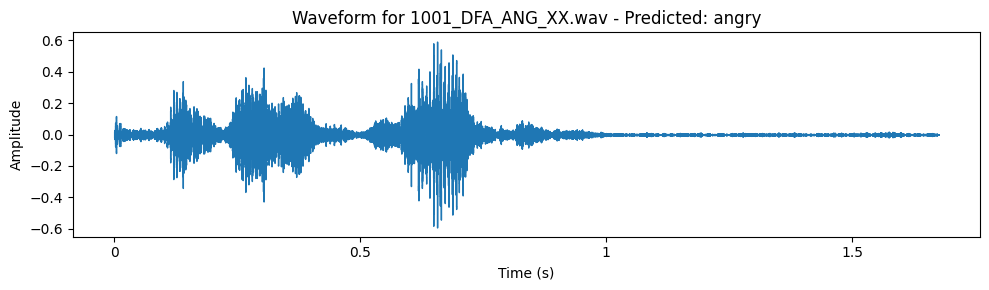

DATA/Crema/1001_DFA_FEA_XX.wav --> Predicted Emotion: angry


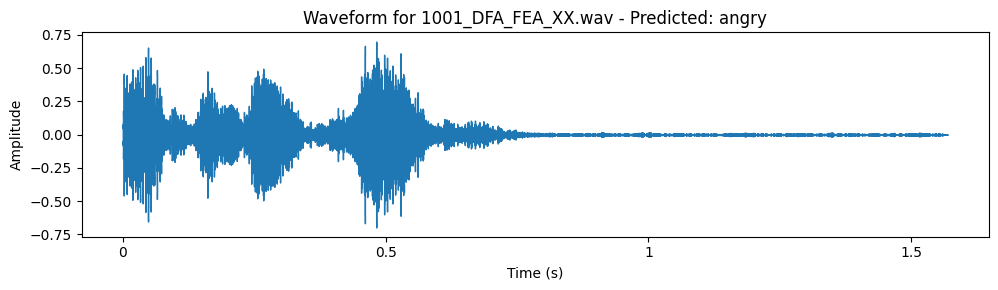

DATA/Crema/1001_DFA_HAP_XX.wav --> Predicted Emotion: angry


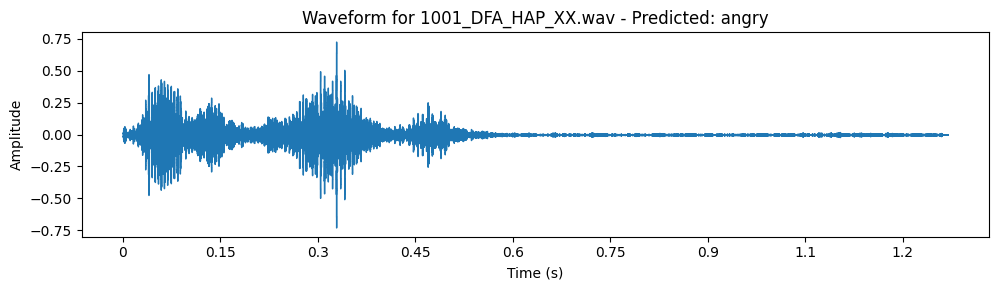

DATA/Crema/1001_IOM_NEU_XX.wav --> Predicted Emotion: fear


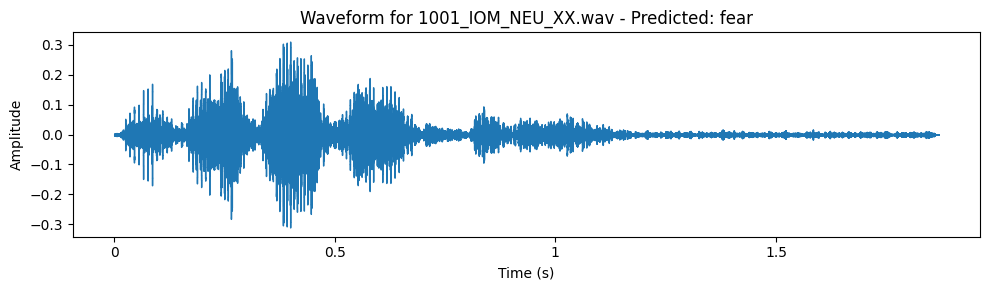

DATA/Crema/1001_IOM_SAD_XX.wav --> Predicted Emotion: neutral


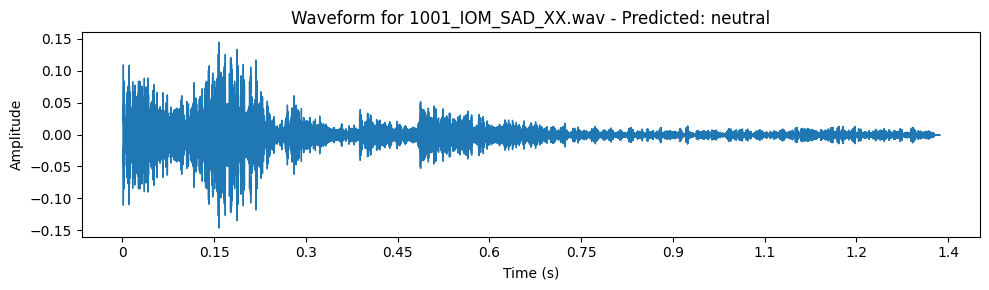

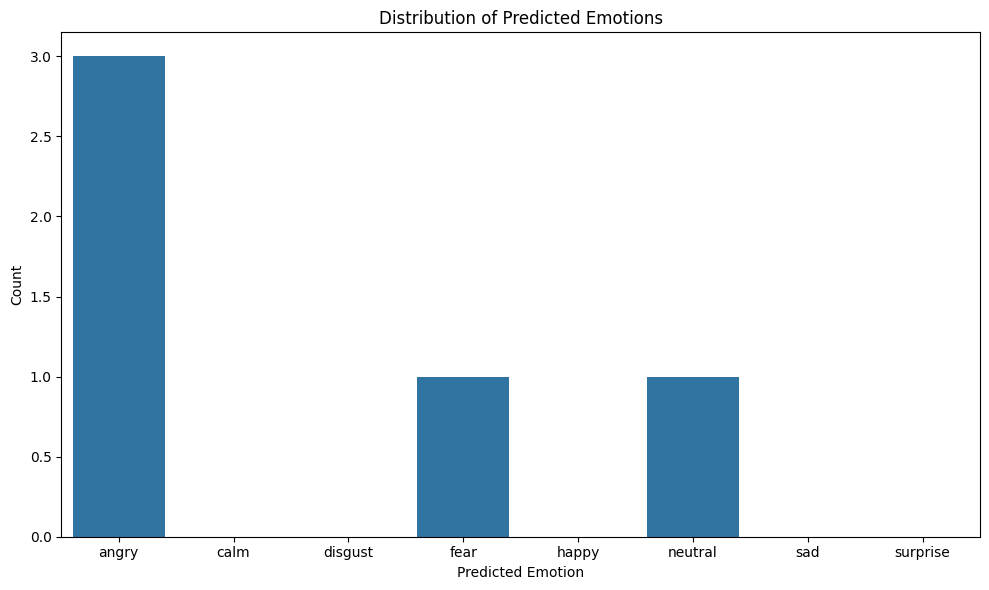

In [3]:
# Importing additional library for waveform visualization
import librosa.display

# Function to preprocess, predict, and visualize
def preprocess_predict_visualize(file_paths, model):
    predictions = []
    for file_path in file_paths:
        # Load the audio file
        data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
        
        # Extract features
        features = extract_features(data, sample_rate)
        
        # Scale features using the same scaler used during training
        scaled_features = scaler.transform(features.reshape(1, -1))
        scaled_features = np.expand_dims(scaled_features, axis=2)  # Add channel dimension
        
        # Predict emotion
        prediction = model.predict(scaled_features)
        predicted_label = encoder.categories_[0][np.argmax(prediction)]
        predictions.append((file_path, predicted_label, data, sample_rate))
    
    return predictions

# Get predictions and their corresponding waveforms
test_predictions = preprocess_predict_visualize(test_file_paths, model)

# Print predictions and visualize waveforms
print("Predictions for test audio files:")
predicted_labels = []  # For visualization
for i, (file_path, predicted_label, data, sample_rate) in enumerate(test_predictions):
    print(f"{file_path} --> Predicted Emotion: {predicted_label}")
    predicted_labels.append(predicted_label)
    
    # Plot waveform for each audio file
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sample_rate)
    plt.title(f"Waveform for {os.path.basename(file_path)} - Predicted: {predicted_label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Visualize the distribution of predicted emotions
plt.figure(figsize=(10, 6))
sns.countplot(x=predicted_labels, order=encoder.categories_[0])
plt.title("Distribution of Predicted Emotions")
plt.xlabel("Predicted Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
